#### Важное требование ко всей домашке в целом: в jupyter ноутбуке не должно был лишнего кода (т.е. если вы взяли за основу семинар, не забудьте удалить все лишнее)

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()
%matplotlib inline

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)  
3) измените часть с np.random.randint(vocab_size) так, чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов (частотные должны выбираться реже, а редкие чаще)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [16]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    norms = [morph.parse(word)[0].normal_form for word in tokens if word]
    return norms

In [5]:
wiki = open('wiki_data.txt', encoding='utf-8').read().split('\n')

In [15]:
bool('')

False

In [17]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [7]:
len(vocab)

356181

In [18]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [10]:
len(filtered_vocab)

11987

In [19]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [20]:
id2word = {i:word for word, i in word2id.items()}

In [21]:
probs = Counter({x:vocab[x] for x in filtered_vocab})

In [23]:
probs

Counter({'апостольский': 45,
         'ген': 123,
         'разрушать': 63,
         'увлечься': 59,
         'ферма': 191,
         'больница': 374,
         'высечь': 32,
         'адрес': 205,
         'салгейра': 40,
         'обоснование': 70,
         'курс': 850,
         'предусмотреть': 132,
         'поместье': 120,
         'казаться': 188,
         'сливаться': 41,
         'написать': 1633,
         'полость': 121,
         'вообще': 199,
         'переправиться': 82,
         'черноморский': 263,
         'александра': 32,
         'дворянство': 75,
         'санный': 87,
         'закрепить': 165,
         'рот': 112,
         '1855': 115,
         '2010/11': 42,
         'производство': 1351,
         'схватить': 56,
         'организовывать': 65,
         'вращаться': 89,
         'льгота': 43,
         'светский': 132,
         'продолжаться': 446,
         'понятно': 32,
         'тактический': 90,
         'периферический': 38,
         'последовательный': 69,
     

In [25]:
N = sum(probs.values())
reverse_vocab = Counter({x: 1-probs[x]/N for x in filtered_vocab})

In [31]:
sum_weights = sum(reverse_vocab.values())
weights = [w / sum_weights for w in reverse_vocab.values()] 

In [32]:
sum(weights)

1.0000000000000027

In [38]:
np.random.choice(list(reverse_vocab.keys()), p=weights)

'единство'

In [42]:

sentences = []

for text in wiki:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [39]:
vocab_size = len(id2word)

Дабы избавиться от оконных путаниц, введем аргумент "целое окно", который будет делиться на два перед запуском цикла. 

In [43]:
# skip gram
def gen_batches_sg(sentences, whole_window=10, batch_size=1000):
    window = int(whole_window/2)
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(word2id[np.random.choice(list(reverse_vocab.keys()), p=weights)])
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []


# # cbow 
def gen_batches_cbow(sentences, whole_window = 10, batch_size=1000):
    window = int(whole_window/2)
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(word2id[np.random.choice(list(reverse_vocab.keys()), p=weights)])
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [44]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_sg = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_sg.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])




In [46]:
model_sg.fit(gen_batches_sg(sentences[:19000], whole_window=12),
          validation_data=gen_batches_sg(sentences[19000:],  whole_window=12),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
10000/10000 [==============================] - 26506s 3s/step - loss: 0.4438 - accuracy: 0.8012 - val_loss: 0.5371 - val_accuracy: 0.7698
Epoch 2/2
10000/10000 [==============================] - 26589s 3s/step - loss: 0.4370 - accuracy: 0.8091 - val_loss: 0.4372 - val_accuracy: 0.8108


In [47]:
embeddings_sg = model_sg.layers[2].get_weights()[0]

In [50]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [55]:
most_similar('машина', embeddings_sg)

['машина',
 'автомобиль',
 'двигатель',
 'конструкция',
 'стойка',
 'колесо',
 'рычаг',
 'задний',
 'ось',
 'улучшить']

In [62]:
most_similar('картина', embeddings_sg)

['картина',
 'видео',
 'пьеса',
 'узнавать',
 'написать',
 'мотив',
 'сценарий',
 'рассказ',
 'сюжет',
 'текст']

In [48]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_cbow = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_cbow.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [63]:
model_cbow.fit(gen_batches_cbow(sentences[:19000], whole_window=6),
          validation_data=gen_batches_cbow(sentences[19000:],  whole_window=6),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
5000/5000 [==============================] - 11206s 2s/step - loss: 0.3663 - accuracy: 0.8425 - val_loss: 0.2985 - val_accuracy: 0.8789
Epoch 2/2
5000/5000 [==============================] - 11405s 2s/step - loss: 0.2732 - accuracy: 0.8878 - val_loss: 0.2598 - val_accuracy: 0.8939


In [68]:
embeddings_cbow = model_cbow.layers[2].get_weights()[0]

In [69]:
most_similar('динозавр', embeddings_cbow)

['динозавр',
 'теризинозавр',
 'крокодил',
 'двукрылый',
 'рептилия',
 'вымереть',
 'ядовитый',
 'дятел',
 'подрод',
 'приапулида']

In [70]:
most_similar('скрипка', embeddings_cbow)

['скрипка',
 'фортепиано',
 'виолончель',
 'струнный',
 'духов',
 'репетиция',
 'рисование',
 'фольклорный',
 'клавишный',
 'тенор']

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [66]:
import gensim

In [64]:
texts = [preprocess(text) for text in wiki]

In [ ]:
f = open('corpus.txt', 'w')
for text in texts:
    f.write(' '.join(text) + '\n')
f.close()

In [71]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             vector_size=256, #легенды гласят, что вектор-степень двойки увеличивает скорость! 
                             min_count=25, #немного расширим min_count и max_vocab
                             max_vocab_size=12000, 
                             window=11, #окно побольше, раз уж cbow не так к этому чувствителен
                             epochs=5, #уменьшим количество проходов
                             hs=1,
                             sample=1e-4,
                             ns_exponent=0.9,
                             cbow_mean=0) 

Wall time: 19.1 s


In [78]:
w2v.wv.most_similar('мать')

[('отец', 0.705590009689331),
 ('сын', 0.661644697189331),
 ('муж', 0.6549494862556458),
 ('сестра', 0.6521973609924316),
 ('ребёнок', 0.6489817500114441),
 ('жена', 0.6475447416305542),
 ('он', 0.6262015700340271),
 ('родитель', 0.6229196190834045),
 ('младший', 0.6178892850875854),
 ('брат', 0.6167949438095093)]

In [81]:
w2v.wv.most_similar('генерал')

[('командующий', 0.6467781066894531),
 ('полковник', 0.6440025568008423),
 ('армия', 0.6264971494674683),
 ('генерал-майор', 0.6227968335151672),
 ('армейский', 0.6073492765426636),
 ('командовать', 0.6024458408355713),
 ('майор', 0.5824628472328186),
 ('приказать', 0.5823227167129517),
 ('войско', 0.5817952752113342),
 ('назначить', 0.5645031332969666)]

In [83]:
ft = gensim.models.FastText(texts, hs=1, min_n=2, max_n=7, sample=1e-4, epochs=5, vector_size=256, min_count= 25)

In [85]:
ft.wv.most_similar('динозавр')

[('теризинозавр', 0.82984858751297),
 ('дейнозуха', 0.673393726348877),
 ('черепаха', 0.6211660504341125),
 ('муха', 0.6106494665145874),
 ('муравей', 0.5621770024299622),
 ('ящерица', 0.5546694397926331),
 ('змея', 0.5536898374557495),
 ('череп', 0.5492599010467529),
 ('червь', 0.536482036113739),
 ('хищник', 0.5353471040725708)]

In [86]:
ft.wv.most_similar('кузов')

[('кутузов', 0.796800971031189),
 ('мотор', 0.6099566221237183),
 ('узор', 0.6095985770225525),
 ('грузовой', 0.608325719833374),
 ('колесо', 0.6075037717819214),
 ('тягач', 0.6038321256637573),
 ('подвеска', 0.5905059576034546),
 ('коробка', 0.5828811526298523),
 ('грузовик', 0.5822262167930603),
 ('тепловоз', 0.5815256834030151)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [84]:
data = pd.read_csv('labeled.csv')

In [87]:
data['norm']=data.comment.apply(preprocess)

In [89]:
!pip install pymystem3

  Using cached https://files.pythonhosted.org/packages/00/8c/98b43c5822620458704e187a1666616c1e21a846ede8ffda493aabe11207/pymystem3-0.2.0-py3-none-any.whl


You are using pip version 19.0.3, however version 22.1b1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [90]:
from pymystem3 import Mystem
m = Mystem()

In [91]:
mapping = {}

for line in open('ru-rnc.map.txt'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [92]:

def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens


In [93]:
data['mystem'] = data.comment.apply(normalize_mystem)

In [100]:
len(ft.wv[0])

256

In [97]:
len(embeddings_cbow[0])

300

In [182]:
def get_model(embs, col='norm', w2id=word2id, optimizer=tf.keras.optimizers.Adam()):

    vec_size = len(embs[0])
    vocab = Counter()

    for text in data[col]:
        vocab.update(text)
        
    filtered_vocab = set()

    for word in vocab:
        if vocab[word] > 5:
            filtered_vocab.add(word)


    word2id = { 'PAD':0}

    for word in filtered_vocab:
        word2id[word] = len(word2id)
    id2word = {i:word for word, i in word2id.items()}

    X = []

    for tokens in data[col]:
        ids = [word2id[token] for token in tokens if token in word2id]
        X.append(ids)
    X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
    y = data.toxic.values

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)
    weights = np.zeros((len(word2id), vec_size))
    if type(embs)!="<class 'numpy.ndarray'>":
        for word, i in word2id.items():
            # вектор паддинга оставим нулевым
            if word == 'PAD':
                continue

            try:
                weights[i] = embs[w2id[word]]
            
            
            except KeyError:
                continue
    else:
        for word, i in word2id.items():
            # вектор паддинга оставим нулевым
            if word == 'PAD':
                continue

            try:
                weights[i] = embs[word]
            
            
            except KeyError:
                weights[i] = embs['и']
    

    inputs = tf.keras.layers.Input(shape=(100,))

    # передаем матрицу в эмбединг слой
    # указываем параметр trainable=False, чтобы вектора не обучались
    # Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
    # эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
    # обучатся заново
    embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=vec_size, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
    mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
    model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)
    print(model.history.history.keys())
    # summarize history for accuracy
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return model


Epoch 1/30
428/428 [==============================] - 2s 3ms/step - loss: 0.6341 - accuracy: 0.6631 - val_loss: 0.6515 - val_accuracy: 0.6283
Epoch 2/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6115 - accuracy: 0.6671 - val_loss: 0.6475 - val_accuracy: 0.6283
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6053 - accuracy: 0.6672 - val_loss: 0.6410 - val_accuracy: 0.6283
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.5997 - accuracy: 0.6672 - val_loss: 0.6357 - val_accuracy: 0.6283
Epoch 5/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5944 - accuracy: 0.6672 - val_loss: 0.6302 - val_accuracy: 0.6283
Epoch 6/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5895 - accuracy: 0.6672 - val_loss: 0.6247 - val_accuracy: 0.6283
Epoch 7/30
428/428 [==============================] - 1s 2ms/step - loss: 0.5849 - accuracy: 0.6674 - val_loss: 0.6196 - val_accuracy: 0.6283
Epoch 

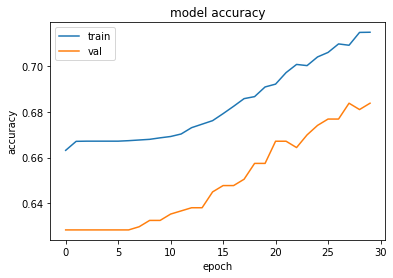

In [128]:
get_model(embeddings_cbow)

Epoch 1/30
428/428 [==============================] - 2s 3ms/step - loss: 0.6388 - accuracy: 0.6645 - val_loss: 0.6257 - val_accuracy: 0.6533
Epoch 2/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6119 - accuracy: 0.6658 - val_loss: 0.6216 - val_accuracy: 0.6533
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6067 - accuracy: 0.6658 - val_loss: 0.6180 - val_accuracy: 0.6533
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6026 - accuracy: 0.6658 - val_loss: 0.6152 - val_accuracy: 0.6533
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.5987 - accuracy: 0.6658 - val_loss: 0.6119 - val_accuracy: 0.6533
Epoch 6/30
428/428 [==============================] - 1s 3ms/step - loss: 0.5952 - accuracy: 0.6658 - val_loss: 0.6094 - val_accuracy: 0.6533
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.5920 - accuracy: 0.6658 - val_loss: 0.6071 - val_accuracy: 0.6533
Epoch 

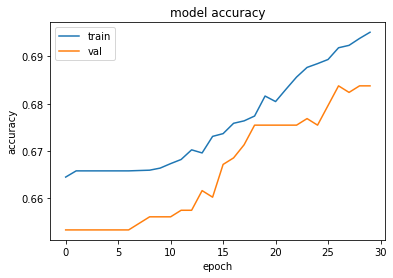

In [129]:
get_model(embeddings_sg)

Epoch 1/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6557 - accuracy: 0.6640 - val_loss: 0.6378 - val_accuracy: 0.6616
Epoch 2/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6249 - accuracy: 0.6653 - val_loss: 0.6306 - val_accuracy: 0.6616
Epoch 3/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6193 - accuracy: 0.6653 - val_loss: 0.6296 - val_accuracy: 0.6616
Epoch 4/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6171 - accuracy: 0.6653 - val_loss: 0.6286 - val_accuracy: 0.6616
Epoch 5/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6155 - accuracy: 0.6653 - val_loss: 0.6275 - val_accuracy: 0.6616
Epoch 6/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6141 - accuracy: 0.6653 - val_loss: 0.6263 - val_accuracy: 0.6616
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6127 - accuracy: 0.6653 - val_loss: 0.6251 - val_accuracy: 0.6616
Epoch 

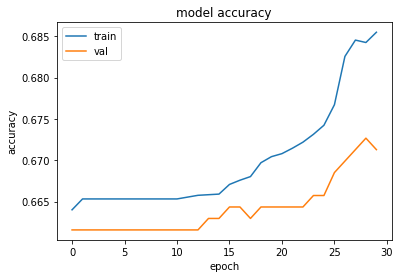

In [130]:
get_model(w2v.wv)

Epoch 1/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6196 - accuracy: 0.6626 - val_loss: 0.5812 - val_accuracy: 0.6907
Epoch 2/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6154 - accuracy: 0.6638 - val_loss: 0.5782 - val_accuracy: 0.6907
Epoch 3/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6139 - accuracy: 0.6638 - val_loss: 0.5795 - val_accuracy: 0.6907
Epoch 4/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6131 - accuracy: 0.6638 - val_loss: 0.5785 - val_accuracy: 0.6907
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6121 - accuracy: 0.6638 - val_loss: 0.5780 - val_accuracy: 0.6907
Epoch 6/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6114 - accuracy: 0.6638 - val_loss: 0.5791 - val_accuracy: 0.6907
Epoch 7/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6105 - accuracy: 0.6638 - val_loss: 0.5802 - val_accuracy: 0.6907
Epoch 

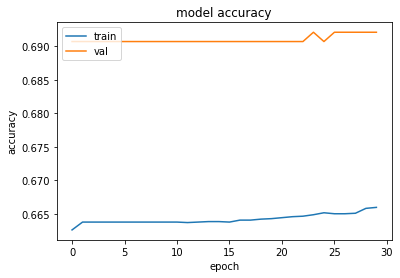

In [188]:
get_model(ft.wv)

К сожалению, хранилище векторов с rusvectores не дает мне скачать ни одну модель (даже с ВПН), поэтому пришлось безо всяких истинных мотиваций взять ruwikiruscorpora_upos_skipgram_300_2_2019, потому что она и так была у меня на компьютере. Во всяком случае, хорошо, что она обучена еще и на НКРЯ.

In [172]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('./model_wiki.bin', binary=True)

Не совсем понимаю, почему, но точность не меняется, и валидационная выборка изначально точнее трейна. Пробовала менять на sgd, не помогло. Аналогично с предыдущей моделью. И побеждает gensim-fasttext.

Epoch 1/30
428/428 [==============================] - 2s 3ms/step - loss: 0.6465 - accuracy: 0.6649 - val_loss: 0.6354 - val_accuracy: 0.6699
Epoch 2/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6380 - accuracy: 0.6649 - val_loss: 0.6344 - val_accuracy: 0.6699
Epoch 3/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6378 - accuracy: 0.6649 - val_loss: 0.6343 - val_accuracy: 0.6699
Epoch 4/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6378 - accuracy: 0.6649 - val_loss: 0.6343 - val_accuracy: 0.6699
Epoch 5/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6378 - accuracy: 0.6649 - val_loss: 0.6343 - val_accuracy: 0.6699
Epoch 6/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6378 - accuracy: 0.6649 - val_loss: 0.6343 - val_accuracy: 0.6699
Epoch 7/30
428/428 [==============================] - 1s 2ms/step - loss: 0.6378 - accuracy: 0.6649 - val_loss: 0.6343 - val_accuracy: 0.6699
Epoch 

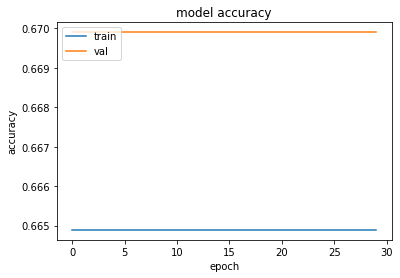

In [191]:
get_model(model, col='mystem')